# AI-PBPK model project: hyperparameters tuning with BayesSearchCV
Author: Kun Mi
Date created: 2025/05/07

Description: In this study, we used ML and Deep nerual network models to predict the require parameter which can be inputed into the PBPK model  


# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]
!pip install -q keras-tuner
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.0 MB/s eta 0:00:00


In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/2-AI-PBPK"

# choose where you want your project files to be saved
project_folder = "/Final model/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-1.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

,0
Ori,152
ID,0
Type,0
TS,0
MAT,0
Size,46
Zeta,71
Charge,66
Shape,0
TM,0


In [ ]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
df = pd.DataFrame(Data)
q_high=df["KTRESmax"].quantile(0.975)
q_low=df["KTRESmax"].quantile(0.025)
df_filtered=df[(df["KTRESmax"]<q_high)&(df["KTRESmax"]>q_low)]
df_X = df_filtered[["Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_filtered[["KTRESmax"]]

In [ ]:
#Define the variable type
cols_num = ['Size','Zeta','TSz'] #Numerical value
cols_label = ["Type",'TS','Charge','Shape','TM','CT','MAT'] # Label value

# 3. One-hot Encoding



In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_Hybrid  Type_Inorganic  Type_Organic  TS_Active  TS_Passive  \
0            0.0             1.0           0.0        1.0         0.0   
1            0.0             1.0           0.0        0.0         1.0   
2            0.0             1.0           0.0        0.0         1.0   
3            0.0             1.0           0.0        1.0         0.0   
4            0.0             1.0           0.0        0.0         1.0   
..           ...             ...           ...        ...         ...   
397          0.0             0.0           1.0        0.0         1.0   
398          0.0             0.0           1.0        0.0         1.0   
399          1.0             0.0           0.0        1.0         0.0   
400          0.0             0.0           1.0        0.0         1.0   
401          0.0             0.0           1.0        0.0         1.0   

     Charge_Negative  Charge_Neutral  Charge_Positive  Shape_Others  \
0                0.0             1.0              0.

# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size      Zeta       TSz
0    0.086602  0.440698  0.176214
1    0.078449  0.440698  0.176214
2    0.359850  0.433368  0.255823
3    0.381005  0.440698  0.255823
4    0.223667  0.404046  0.255823
..        ...       ...       ...
397  0.022697  0.472218  0.066325
398  0.042750  0.471485  0.066325
399  0.214412  0.375443  0.131465
400  0.038123  0.475150  0.018950
401  0.366681  0.351268  0.013028

[402 rows x 3 columns]


# Compile data

In [ ]:
preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)
print(preData)

         Size      Zeta       TSz  Type_Hybrid  Type_Inorganic  Type_Organic  \
0    0.086602  0.440698  0.176214          0.0             1.0           0.0   
1    0.078449  0.440698  0.176214          0.0             1.0           0.0   
2    0.359850  0.433368  0.255823          0.0             1.0           0.0   
3    0.381005  0.440698  0.255823          0.0             1.0           0.0   
4    0.223667  0.404046  0.255823          0.0             1.0           0.0   
..        ...       ...       ...          ...             ...           ...   
397  0.022697  0.472218  0.066325          0.0             0.0           1.0   
398  0.042750  0.471485  0.066325          0.0             0.0           1.0   
399  0.214412  0.375443  0.131465          1.0             0.0           0.0   
400  0.038123  0.475150  0.018950          0.0             0.0           1.0   
401  0.366681  0.351268  0.013028          0.0             0.0           1.0   

     TS_Active  TS_Passive  Charge_Nega

# Define X and y

In [ ]:
y_re = df_y
X_re = preData

#Data split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(321, 42) (81, 42) (321, 1) (81, 1)


# LightGbm model with pretest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.kernel_ridge import KernelRidge

###Kernel Ridge

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#KernelRidge
def objective(trial):
    param = {
    "kernel": trial.suggest_categorical("kernel", ["rbf"]),
    "alpha": trial.suggest_loguniform("alpha", 1e-4, 1e-1),
    "gamma": trial.suggest_loguniform("gamma", 1e-4, 1e-1),
    }

    model = KernelRidge(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)

    return Score

# Optimization
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

Best parameters: {'kernel': 'rbf', 'alpha': 0.0977167665005199, 'gamma': 0.09145707731991802}
Best R² score: 0.0992


In [ ]:
### Develop the best model
best_params = study.best_params
KRR = KernelRidge(**best_params)

KRR.fit(X_train, y_train)

train_preds = KRR.predict(X_train)
test_preds = KRR.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # Predict on the test set
# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=477)

# Cross-validation scores
cv_r2 = cross_val_score(KRR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(KRR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.4986586489988335
Trian set RMSE 1.9182720813733949
---------------------------------------------------------------------
Test set r2 0.09921424256042588
Test set RMSE 3.0159501047214428

Cross-Validation Performance:
R2 Score : 0.044 ± 0.222
RMSE     : 2.595 ± 0.531


###Random forest

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#Random forest model
def objective(trial):
    param = {"n_estimators": trial.suggest_int("n_estimators", 200, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2",0.5]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True])}

    model = RandomForestRegressor(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)

    return Score

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)


Best parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
Best r2 score: 0.11104815585713612


In [ ]:
### Develop the best model
best_params = study.best_params
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=4)
# Cross-validation scores
cv_r2 = cross_val_score(rf, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.4127037402751704
Trian set RMSE 2.0762137365909474
---------------------------------------------------------------------
Test set r2 0.08037807219005622
Test set RMSE 3.0473199582825523

Cross-Validation Performance:
R2 Score : 0.066 ± 0.118
RMSE     : 2.541 ± 0.456


##XGBoost

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
# optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000,step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0)

    }

    model = XGBRegressor(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)
    return Score

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 200)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'n_estimators': 850, 'max_depth': 6, 'learning_rate': 0.0016084972179018977, 'subsample': 0.9997306534334707, 'min_child_weight': 2, 'colsample_bytree': 0.9486133588232989, 'gamma': 0.013196738402117181, 'reg_alpha': 4.988113053333023, 'reg_lambda': 0.007323937094827727}
Best r2 score: 0.20021313428878784


In [ ]:
### Develop the best model
best_params = study.best_params
XGB= XGBRegressor(**best_params)
XGB.fit(X_train, y_train)

train_preds = XGB.predict(X_train)
test_preds = XGB.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=35)

# Cross-validation scores
cv_r2 = cross_val_score(XGB, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(XGB, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

Trian set r2 0.5262660384178162
Trian set RMSE 1.8647074699401855
---------------------------------------------------------------------
Test set r2 0.20021313428878784
Test set RMSE 2.841845750808716

Cross-Validation Performance:
R2 Score : 0.020 ± 0.077
RMSE     : 2.659 ± 0.340


## SVM

In [ ]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e3),
        "epsilon": trial.suggest_uniform("epsilon", 0.01, 1.0),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5),
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "coef0": trial.suggest_uniform("coef0", 0.0, 1.0)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)
    return Score


# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'C': 200.9424094150849, 'epsilon': 0.5244370780999362, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.9132499400708893, 'coef0': 0.4012545788918874}
Best r2 score: 0.24809101328768268


In [ ]:
### Develop the best model
from sklearn.svm import SVR

best_params = study.best_params
SVR= SVR(**best_params)
SVR.fit(X_train, y_train)

train_preds = SVR.predict(X_train)
test_preds = SVR.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # # Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=33)

# Cross-validation scores
cv_r2 = cross_val_score(SVR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(SVR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.6031420525741971
Trian set RMSE 1.706714913852911
---------------------------------------------------------------------
Test set r2 0.24809101328768268
Test set RMSE 2.755472205894422

Cross-Validation Performance:
R2 Score : 0.037 ± 0.135
RMSE     : 2.616 ± 0.205


# Deep nerual network model with keras

In [ ]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
import optuna
# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.layers import BatchNormalization

In [ ]:
X = X_re.to_numpy()
y = y_re.to_numpy()
# summarize shape
print(X.shape, y.shape)

(402, 42) (402, 1)


In [ ]:
from sklearn.model_selection import train_test_split
seed=1

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.125, random_state=seed)
print(X_temp.shape, X_test.shape, y_temp.shape, y_test.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(321, 42) (81, 42) (321, 1) (81, 1)
(280, 42) (41, 42) (280, 1) (41, 1)


# Tuning Model with Keras Tuner

In [ ]:
!pip install -q optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from optuna.integration import TFKerasPruningCallback
import tempfile

def objective(trial):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input Layer
    dense_bot = trial.suggest_int('dense_bot', 32, 512, step=32)
    activation = trial.suggest_categorical('dense_activation', ['relu', 'tanh', 'sigmoid'])
    model.add(Dense(dense_bot))
    # model.add(BatchNormalization())
    model.add(Activation(activation))

    # Hidden Layers
    num_layers = trial.suggest_int('num_dense_layers', 1, 4)
    for i in range(num_layers):
        units = trial.suggest_int(f'dense_{i}', 32, 1024, step=32)
        act = trial.suggest_categorical(f'act_{i}', ['relu', 'tanh', 'sigmoid'])
        dropout = trial.suggest_float(f'dropout_{i}', 0.0, 0.6, step=0.2)

        model.add(Dense(units))
        # model.add(BatchNormalization())
        model.add(Activation(act))
        model.add(Dropout(dropout))

    # Output
    model.add(Dense(1, activation='linear'))

    # Optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam','Nadam'])
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_name, 'config': {'learning_rate': lr}})

    model.compile(optimizer=optimizer, loss= MeanSquaredError())

    # Callbacks
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=128,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
            TFKerasPruningCallback(trial, 'val_loss'),
        ]
    )

    # Evaluate
    y_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(y_test, y_pred)

    # Save model
    model_path = tempfile.NamedTemporaryFile(delete=False, suffix=".keras").name
    model.save(model_path)
    trial.set_user_attr("model_path", model_path)

    return r2


In [ ]:
from optuna.pruners import MedianPruner

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=8)
)
study.optimize(objective, n_trials=100)

[I 2025-06-14 20:30:51,179] A new study created in memory with name: no-name-58a2e16f-acdc-4903-b64e-50e9bc47e5ba
[I 2025-06-14 20:31:01,180] Trial 0 finished with value: 0.06829324094969635 and parameters: {'dense_bot': 352, 'dense_activation': 'relu', 'num_dense_layers': 4, 'dense_0': 352, 'act_0': 'relu', 'dropout_0': 0.0, 'dense_1': 352, 'act_1': 'sigmoid', 'dropout_1': 0.4, 'dense_2': 864, 'act_2': 'relu', 'dropout_2': 0.4, 'dense_3': 224, 'act_3': 'sigmoid', 'dropout_3': 0.2, 'optimizer': 'Nadam', 'learning_rate': 0.00023049521782225044}. Best is trial 0 with value: 0.06829324094969635.
[I 2025-06-14 20:31:07,765] Trial 1 finished with value: 0.02637159083292462 and parameters: {'dense_bot': 96, 'dense_activation': 'tanh', 'num_dense_layers': 4, 'dense_0': 576, 'act_0': 'sigmoid', 'dropout_0': 0.2, 'dense_1': 352, 'act_1': 'sigmoid', 'dropout_1': 0.2, 'dense_2': 448, 'act_2': 'sigmoid', 'dropout_2': 0.4, 'dense_3': 768, 'act_3': 'sigmoid', 'dropout_3': 0.4, 'optimizer': 'Adam', '

KeyboardInterrupt: 

In [ ]:
# Load model
best_model_path = study.best_trial.user_attrs["model_path"]
best_model = tf.keras.models.load_model(best_model_path)

# Model prediction
print("Best train R²:",r2_score(y_train, best_model.predict(X_train)))
print("Best train rmse:",root_mean_squared_error(y_train, best_model.predict(X_train)))
print("Best test R²:",r2_score(y_test, best_model.predict(X_test)))
print("Best test rmse:",root_mean_squared_error(y_test, best_model.predict(X_test)))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Best train R²: 0.35553174957274547
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Best train rmse: 2.2432011144401827
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best test R²: 0.21372554950447376
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Best test rmse: 2.3951933184642087


In [ ]:
def build_best_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input
    model.add(Dense(params['dense_bot'], activation=params['dense_activation']))

    # Hidden
    for i in range(params['num_dense_layers']):
        model.add(Dense(params[f'dense_{i}'], activation=params[f'act_{i}']))
        model.add(Dropout(params[f'dropout_{i}']))

    # Output
    model.add(Dense(1, activation='linear'))

    # Optimizer
    if params['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='mse',metrics= ['mae','mse'])
    return model


In [ ]:
params = study.best_trial.params
model = build_best_model(params)

In [ ]:
# save model and architecture to single file
best_model.save("KTRESmax_0515-8.keras")
print("Saved model to disk")

Saved model to disk


In [ ]:
load_model= keras.models.load_model("KTRESmax_0515-3.keras")

In [ ]:
best_model= load_model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stop], epochs=200, batch_size=32, verbose=0)


print("Best train R²:",r2_score(y_temp, best_model.predict(X_temp)))
print("Best train rmse:",root_mean_squared_error(y_temp, best_model.predict(X_temp)))
print("Best test R²:",r2_score(y_test, best_model.predict(X_test)))
print("Best test rmse:",root_mean_squared_error(y_test, best_model.predict(X_test)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Best train R²: 0.4212890923575485
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best train rmse: 2.1578789401056837
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Best test R²: 0.4595901178259453
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Best test rmse: 1.9857068349768008


In [ ]:
# save model and architecture to single file
best_model.save("KTRESmax_0515-7.keras")
print("Saved model to disk")

Saved model to disk


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


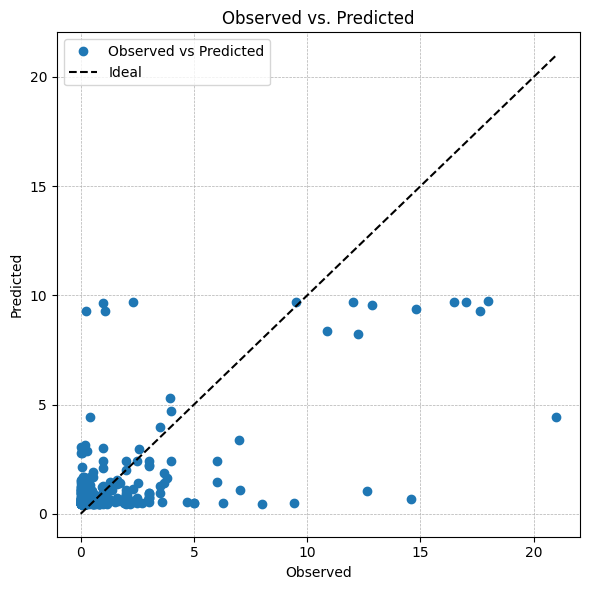

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Model prediction
y_obs = y_re
all_preds = best_model.predict(X_re)

# # Transfer numpy
y_obs = np.ravel(y_obs)
all_preds = np.ravel(all_preds)

#  Plot
plt.figure(figsize=(6, 6))
plt.plot(y_obs, all_preds, 'o', label='Observed vs Predicted')

# y = x
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'k--', label='Ideal')


# Label
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs. Predicted")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
PredKmax = pd.concat([pd.DataFrame(df_filtered["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","Obs_KTRESmax", "Pred_KTRESMAX"]
PredKmax.to_csv('output_KTRESmax.csv', encoding = 'utf-8-sig',index=False)

##Cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow.keras as keras

dnn_base_model = keras.models.load_model("KTRESmax_0515-3.keras")

kfold = KFold(n_splits=5, shuffle=True, random_state=18)
cvr2scores = []
cvrmsescores = []

for fold, (train_ix, test_ix) in enumerate(kfold.split(X_temp), 1):
    X_train_n, X_test_n = X_temp[train_ix], X_temp[test_ix]
    y_train_n, y_test_n = y_temp[train_ix], y_temp[test_ix]

    dnn_model = clone_model(dnn_base_model)
    dnn_model.set_weights(dnn_base_model.get_weights())
    dnn_model.compile(optimizer='Nadam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dnn_model.fit(X_train_n, y_train_n, validation_data=(X_test_n, y_test_n), callbacks=[early_stop],
                  epochs=100, batch_size=32, verbose=0)

    # Fittnees
    test_pred = dnn_model.predict(X_test_n).flatten()
    r2score = r2_score(y_test_n, test_pred)
    rmse = root_mean_squared_error(y_test_n, test_pred)

    print(f"[Fold {fold}] R²: {r2score:.3f}, RMSE: {rmse:.3f}")

    cvr2scores.append(r2score)
    cvrmsescores.append(rmse)

# Print
print("\n=== Cross-validation summary ===")
print("The 5-CV R² Score was: %.2f (+/- %.2f)" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-CV RMSE Score was: %.2f (+/- %.2f)" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[Fold 1] R²: 0.080, RMSE: 2.685
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[Fold 2] R²: 0.432, RMSE: 2.884
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[Fold 3] R²: 0.388, RMSE: 1.999
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[Fold 4] R²: 0.451, RMSE: 1.674
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[Fold 5] R²: 0.512, RMSE: 1.675

=== Cross-validation summary ===
The 5-CV R² Score was: 0.37 (+/- 0.15)
The 5-CV RMSE Score was: 2.18 (+/- 0.51)


#Make the prediction

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-prediction-1.csv"))
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column
df = pd.DataFrame(Data)

df_ori =df.iloc[0:-2]

q_high=df_ori["KTRESmax"].quantile(0.975)
q_low=df_ori["KTRESmax"].quantile(0.025)
df_filtered=df_ori[(df_ori["KTRESmax"]<q_high)&(df_ori["KTRESmax"]>q_low)]

df_merge = pd.concat([df_filtered, df.iloc[-2:]], axis=0)


df_X = df_merge[["ID","Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_merge[["KTRESmax"]]

test_X = df_X

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)

preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)

y_re = df_y
X_re = preData


In [ ]:
from tensorflow import keras
best_model= keras.models.load_model("KTRESmax_0515-3.keras")

all_preds = best_model.predict(X_re.iloc[-2:])
all_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


array([[1.6038427],
       [0.7921417]], dtype=float32)